# Overview

##### - Di notebook ini, akan dilakukan Feature Engineering dan Modelling yang akan memberikan output berupa model ML yang dapat digunakan untuk memprediksi kemungkinan nasabah yang gagal bayar. Model ini nantinya akan membantu tim underwriting fintech/bank untuk membantu proses persetujuan pinjaman.
##### - Model akan dievaluasi menggunakan metriks evaluasi yang relevan untuk meningkatkan keandalan dari sistem ini

### Import library yang digunakan

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from category_encoders import CatBoostEncoder
from sklearn.metrics import classification_report,confusion_matrix, f1_score,precision_score,recall_score,roc_auc_score,accuracy_score
import optuna
import xgboost as xgb
from functools import partial
import pickle

Load data clean hasil Cleaning dan EDA

In [301]:
df = pd.read_csv("..\\data\\german_credit_data_clean.csv")
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,age_bin,credit_bin,duration_bin
0,67,male,2,own,Unknown,little,1169,6,radio/TV,0,"(60, 100]",very low,<=12
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,"(18, 25]",mid,37–48
2,49,male,1,own,little,Unknown,2096,12,education,0,"(40, 50]",low,<=12
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,"(40, 50]",mid,37–48
4,53,male,2,free,little,little,4870,24,car,1,"(50, 60]",low,13-24


### Hal yang perlu dilakukan
- Encoding data kategorikal
- Pertimbangkan penggunaan log transform
- Scaling data numerik
- Feature interactions
- Feature importances

In [302]:
df['Risk'].value_counts()

Risk
0    700
1    300
Name: count, dtype: int64

##### Melakukan split untuk memisahkan data training dan data testing

In [303]:
X = df.drop('Risk',axis=1)
y = df['Risk']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,stratify=y)

##### Membangun transformer kolom dan juga pipeline preprocessing data untuk memastikan keefisienan dalam proses training dan testing model.

In [304]:
categorical_column = ['Sex','Housing','Saving accounts','Checking account','Purpose','age_bin','credit_bin','duration_bin']
# categorical_column = ['Sex','Housing','Saving accounts','Checking account','Purpose']
numerical_column = ['Age','Credit amount','Duration','Job']

def generate_pipeline(model=None,name=''):
    transformers = ColumnTransformer([
        ('column_encoder',OneHotEncoder(),categorical_column),
        # ('catboost_enc', CatBoostEncoder(), categorical_column),
        ('numeric_scaler',StandardScaler(),numerical_column),
        # ('num',StandardScaler(),numerical_column)
    ])

    pipeline = Pipeline([
        ('transformer', transformers),
        ('sampler',RandomUnderSampler(random_state=42)),
        # ('sampler',SMOTE(random_state=42)),
        ('model',model),
    ])

    return pipeline

def train(X_train,y_train,model=None):
    pipeline = generate_pipeline(model=model)
    pipeline.fit(X_train,y_train)
    return pipeline

def test_evaluate(X_test,y_test,model=None):
    y_pred = model.predict(X_test)

    print(f'Acc: {accuracy_score(y_test,y_pred)}')
    print(f'F1: {f1_score(y_test,y_pred)}')
    print(f'Precision: {precision_score(y_test,y_pred)}')
    print(f'Recall: {recall_score(y_test,y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test,y_pred)}')
    print(classification_report(y_test,y_pred))
    heatmap(confusion_matrix(y_test,y_pred))

def heatmap(data, title=""):
    plt.figure(figsize=(5,3))
    sns.heatmap(data, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

##### - Disini saya menggunakan undersampling dengan RandomUnderSampler untuk menangani imbalanced data.
##### - Setelah dilakukan trial dan error, undersampling memberikan hasil evaluasi yang lebih baik dibanding oversampling sehingga undersampling digunakan untuk sampler dalam pipeline.


#### Cross Validation Model untuk Comparison

In [305]:
pipelines = {'log_reg': LogisticRegression(random_state=42,class_weight='balanced'),
             'rf': RandomForestClassifier(random_state=42,class_weight='balanced'),
            #  'xgb': xgb.XGBClassifier(random_state=42),
             }

for name,pipeline in pipelines.items():
    pipes = generate_pipeline(pipeline,name=name)
    scoref1 = cross_val_score(pipes,X,y,cv=10,scoring='f1')
    scorerocauc = cross_val_score(pipes,X,y,cv=10,scoring='roc_auc')
    print(f'Model: {name}')
    print(f'F1-Score per fold: {scoref1}')
    print(f'Rata-rata F1-Score: {scoref1.mean()}')
    print(f'ROC-AUC per fold: {scorerocauc}')
    print(f'Rata-rata ROC-AUC: {scorerocauc.mean()}\n')

Model: log_reg
F1-Score per fold: [0.60240964 0.58666667 0.55882353 0.56756757 0.58974359 0.63636364
 0.46575342 0.67532468 0.61971831 0.56410256]
Rata-rata F1-Score: 0.5866473602251371
ROC-AUC per fold: [0.76857143 0.73095238 0.75666667 0.75857143 0.77857143 0.78809524
 0.58809524 0.85285714 0.77       0.74285714]
Rata-rata ROC-AUC: 0.7535238095238096

Model: rf
F1-Score per fold: [0.56410256 0.56       0.5915493  0.54320988 0.57894737 0.57575758
 0.5        0.59259259 0.62162162 0.51351351]
Rata-rata F1-Score: 0.5641294408326778
ROC-AUC per fold: [0.765      0.73880952 0.75619048 0.76595238 0.71261905 0.76761905
 0.61166667 0.82       0.7847619  0.69309524]
Rata-rata ROC-AUC: 0.7415714285714287



In [306]:
def models(model_name, **params):
    if model_name == "rf":
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(**params,class_weight='balanced')
    elif model_name == "log_reg":
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(**params,class_weight='balanced')
    elif model_name == "xgb":
        from sklearn.linear_model import LogisticRegression
        return xgb.XGBClassifier(**params)
    else:
        raise ValueError("Unknown model name")

#### Setup hyperparameter Tuning dengan optuna untuk model Logistic Regression dan Random Forest

In [307]:
def objective(trial,model_name=''):
    if model_name == 'log_reg':
        params = {
            'C': trial.suggest_float('C', 1e-4, 1000, log=True),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            'max_iter': trial.suggest_int('max_iter', 100, 3500)
        }
    elif model_name == 'rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 32),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
    elif model_name == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 16),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        }
    # Buat pipeline model
    model = generate_pipeline(
        model=models(model_name, **params)
    )

    # Cross-validation
    scores_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
    scores_roc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    trial.set_user_attr('roc_auc', np.mean(scores_roc))
    return np.mean(scores_f1)

studylogreg = optuna.create_study(direction='maximize')
studylogreg.optimize(partial(objective,model_name='log_reg'), n_trials=100)
print(f'Best params : {studylogreg.best_params}')
print(f'Best F1 (CV):{studylogreg.best_value}')

[I 2025-07-28 19:26:54,270] A new study created in memory with name: no-name-43cf58e2-aa38-45f2-8bbd-b68c55756982
[I 2025-07-28 19:26:54,656] Trial 0 finished with value: 0.5757799873512947 and parameters: {'C': 0.9337223915033789, 'solver': 'lbfgs', 'max_iter': 147}. Best is trial 0 with value: 0.5757799873512947.
[I 2025-07-28 19:26:54,892] Trial 1 finished with value: 0.5716165096228392 and parameters: {'C': 0.7841621015995318, 'solver': 'lbfgs', 'max_iter': 2447}. Best is trial 0 with value: 0.5757799873512947.
[I 2025-07-28 19:26:55,126] Trial 2 finished with value: 0.5549814788666327 and parameters: {'C': 0.005534588424001036, 'solver': 'liblinear', 'max_iter': 2371}. Best is trial 0 with value: 0.5757799873512947.
[I 2025-07-28 19:26:55,663] Trial 3 finished with value: 0.5704342162396874 and parameters: {'C': 3.240575355607851, 'solver': 'lbfgs', 'max_iter': 3229}. Best is trial 0 with value: 0.5757799873512947.
[I 2025-07-28 19:26:55,900] Trial 4 finished with value: 0.5745534

Best params : {'C': 0.034202932938473644, 'solver': 'lbfgs', 'max_iter': 1792}
Best F1 (CV):0.5884082674547807


In [308]:
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective,model_name='rf'), n_trials=100)
print(f'Best params : {study.best_params}')
print(f'Best F1 (CV):{study.best_value}')

[I 2025-07-28 19:27:16,967] A new study created in memory with name: no-name-d245f92a-8d0f-4ed9-85be-5bfc471fe5b0
[I 2025-07-28 19:27:20,043] Trial 0 finished with value: 0.5745619580145405 and parameters: {'n_estimators': 207, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5745619580145405.
[I 2025-07-28 19:27:21,474] Trial 1 finished with value: 0.5800054849643039 and parameters: {'n_estimators': 92, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.5800054849643039.
[I 2025-07-28 19:27:27,010] Trial 2 finished with value: 0.576109080942103 and parameters: {'n_estimators': 400, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.5800054849643039.
[I 2025-07-28 19:27:29,154] Trial 3 finished with value: 0.5862872255857751 and parameters: {'n_estimators': 144, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 3 with value

Best params : {'n_estimators': 68, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 10}
Best F1 (CV):0.5885050088915641


In [309]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(partial(objective,model_name='xgb'), n_trials=100)
print(f'Best params : {study_xgb.best_params}')
print(f'Best F1 (CV):{study_xgb.best_value}')

[I 2025-07-28 19:32:54,680] A new study created in memory with name: no-name-0d1bfb63-79a6-48dd-bebf-2cc9ca85b73e
[I 2025-07-28 19:32:55,685] Trial 0 finished with value: 0.5759355192862436 and parameters: {'n_estimators': 208, 'max_depth': 15, 'learning_rate': 0.07075976405466085, 'subsample': 0.6892280584094566, 'colsample_bytree': 0.5126128864459278, 'gamma': 1.7313820819944086, 'reg_lambda': 0.37482371709020057, 'reg_alpha': 0.4391045404259409}. Best is trial 0 with value: 0.5759355192862436.
[I 2025-07-28 19:32:56,268] Trial 1 finished with value: 0.5302272359778482 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.15974437709709102, 'subsample': 0.9516363781475285, 'colsample_bytree': 0.6972927608324517, 'gamma': 4.161875400268907, 'reg_lambda': 2.5406901889514675, 'reg_alpha': 5.969282421461871}. Best is trial 0 with value: 0.5759355192862436.
[I 2025-07-28 19:32:57,202] Trial 2 finished with value: 0.5682463064058215 and parameters: {'n_estimators': 402, 

Best params : {'n_estimators': 407, 'max_depth': 10, 'learning_rate': 0.009151385771231108, 'subsample': 0.6190886121484503, 'colsample_bytree': 0.5879193040691257, 'gamma': 2.229707446857695, 'reg_lambda': 1.6513708705359682, 'reg_alpha': 0.4951905681680861}
Best F1 (CV):0.5968963221996019


#### Dari kedua tuning yang dilakukan, F1 Score dari model Random Forest sedikit lebih baik dibanding model Logistic Regression. Selanjutnya dilakukan training model dan melakukan testing

#### Modelling baseline Logistic Regression

Acc: 0.7
F1: 0.6103896103896104
Precision: 0.5
Recall: 0.7833333333333333
ROC-AUC: 0.7238095238095238
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       140
           1       0.50      0.78      0.61        60

    accuracy                           0.70       200
   macro avg       0.69      0.72      0.68       200
weighted avg       0.76      0.70      0.71       200



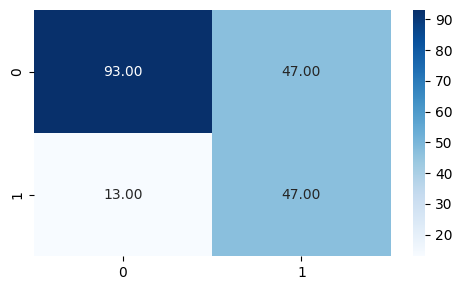

In [318]:
model_LogReg = train(X_train,y_train,LogisticRegression(random_state=42,class_weight='balanced')) 

test_evaluate(X_test,y_test,model_LogReg)

#### Modelling Logistic Regression + Hyperparameter Tuning

Acc: 0.705
F1: 0.6242038216560509
Precision: 0.5051546391752577
Recall: 0.8166666666666667
ROC-AUC: 0.736904761904762
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       140
           1       0.51      0.82      0.62        60

    accuracy                           0.70       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.78      0.70      0.72       200



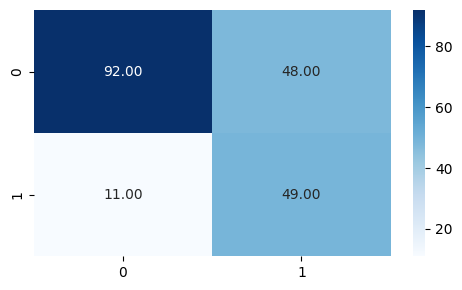

In [319]:
model_LogReg_tuned = train(X_train,y_train,LogisticRegression(random_state=42,class_weight='balanced',**studylogreg.best_params)) 

test_evaluate(X_test,y_test,model_LogReg_tuned)

#### Modelling baseline Random Forest

Acc: 0.72
F1: 0.6363636363636364
Precision: 0.5212765957446809
Recall: 0.8166666666666667
ROC-AUC: 0.7476190476190476
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       140
           1       0.52      0.82      0.64        60

    accuracy                           0.72       200
   macro avg       0.71      0.75      0.70       200
weighted avg       0.78      0.72      0.73       200



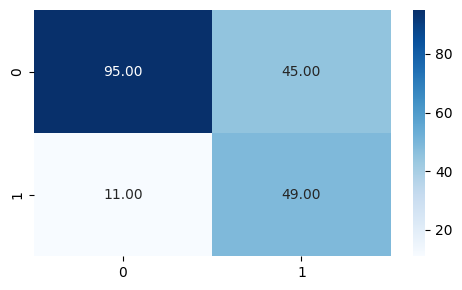

In [320]:
model_Rf = train(X_train,y_train,RandomForestClassifier(random_state=42,class_weight='balanced')) 

test_evaluate(X_test,y_test,model_Rf)

#### Modelling RF + Hyperparameter Tuning

Acc: 0.72
F1: 0.6363636363636364
Precision: 0.5212765957446809
Recall: 0.8166666666666667
ROC-AUC: 0.7476190476190476
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       140
           1       0.52      0.82      0.64        60

    accuracy                           0.72       200
   macro avg       0.71      0.75      0.70       200
weighted avg       0.78      0.72      0.73       200



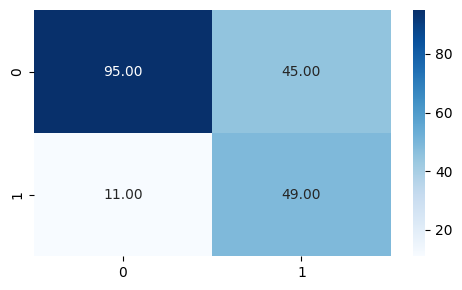

In [321]:
model_Rf_tuned = train(X_train,y_train,RandomForestClassifier(random_state=42,class_weight='balanced',**study.best_params)) 

test_evaluate(X_test,y_test,model_Rf_tuned)

Acc: 0.665
F1: 0.5732484076433121
Precision: 0.4639175257731959
Recall: 0.75
ROC-AUC: 0.6892857142857143
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       140
           1       0.46      0.75      0.57        60

    accuracy                           0.67       200
   macro avg       0.66      0.69      0.65       200
weighted avg       0.74      0.67      0.68       200



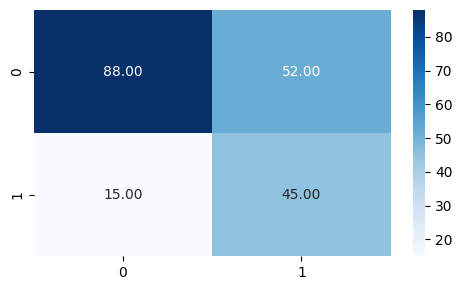

In [322]:
model_xgb = train(X_train,y_train,xgb.XGBClassifier(random_state=42)) 

test_evaluate(X_test,y_test,model_xgb)

Acc: 0.71
F1: 0.6233766233766234
Precision: 0.5106382978723404
Recall: 0.8
ROC-AUC: 0.7357142857142858
              precision    recall  f1-score   support

           0       0.89      0.67      0.76       140
           1       0.51      0.80      0.62        60

    accuracy                           0.71       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.77      0.71      0.72       200



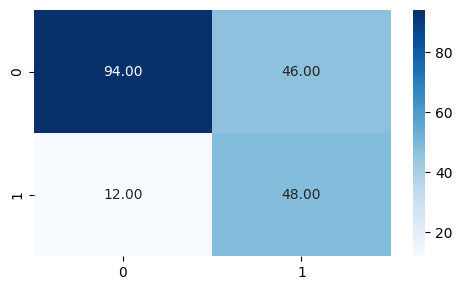

In [323]:
model_xgb_tuned = train(X_train,y_train,xgb.XGBClassifier(random_state=42,**study_xgb.best_params)) 

test_evaluate(X_test,y_test,model_xgb_tuned)

#### Summary
- Hasil Menunjukkan model Random Forest lebih baik dibanding Logistic Regression dan XGB baik secara parameter default ataupun menggunakan parameter optimal.

##### Selanjutnya akan berfokus pada model Random Forest. Disini akan dilakukan treshold tuning untuk menemukan treshold optimal dengan F1-Score tertinggi

Best threshold: 0.54 | Best F1-score: 0.6622 | Best Recall: 0.8167 | Best Precision: 0.5568


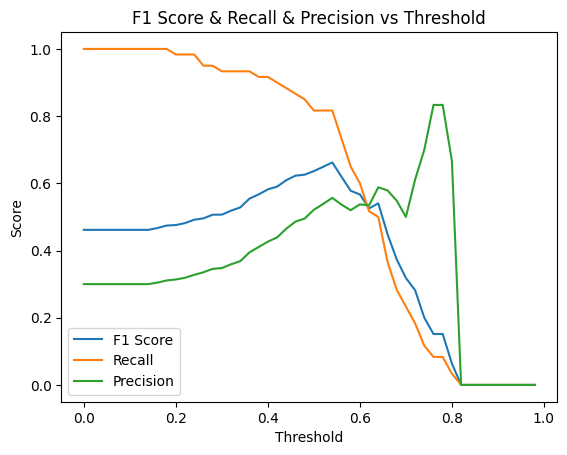

In [334]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
thresholds = np.arange(0, 1, 0.02)
f1_scores = []
recall_scores = []
precision_scores = []

y_proba = model_Rf_tuned.predict_proba(X_test)[:, 1]

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    precision = precision_score(y_test, y_pred_thr)
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_recall = recall_scores[best_idx]
best_precision = precision_scores[best_idx]

print(f"Best threshold: {best_threshold:.2f} | Best F1-score: {best_f1:.4f} | Best Recall: {best_recall:.4f} | Best Precision: {best_precision:.4f}")

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, precision_scores, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 Score & Recall & Precision vs Threshold')
plt.legend()
plt.show()

### **Insight**

* Setelah dilakukan threshold tuning, model memperoleh **F1-Score sebesar 0.6622** dan **recall 0.8167** pada threshold **0.54**.
* **F1-Score 0.6622** menunjukkan model cukup baik dalam menyeimbangkan antara **precision** (akurasi prediksi “bad”) dan **recall** (kemampuan menangkap seluruh nasabah “bad”).
* **Recall 0.8167** menandakan model sangat baik dalam mendeteksi calon nasabah berisiko gagal bayar (*bad*), sehingga potensi risiko kredit macet dapat ditekan.
* **Precision 0.5568** mengindikasikan sekitar 55% prediksi “bad” memang benar-benar nasabah “bad”. Artinya, masih ada sekitar 45% calon nasabah “good” yang berpotensi tertolak (false positive).
* Model ini dapat dijadikan alat bantu bagi tim underwriting dalam mempertimbangkan approval kredit, dengan **fokus utama pada meminimalisir risiko pemberian kredit kepada nasabah berisiko tinggi**.

### Save model dan X_test,y_test untuk dipakai di notebook 3

In [335]:
with open("..//model//model_prediksi-kredit.pkl",'wb') as file:
    pickle.dump(model_Rf_tuned, file)

X_test.to_csv("..//data//x_test.csv",index=False)
y_test.to_csv("..//data//y_test.csv",index=False)